In [1]:
import os
import matplotlib.pyplot as plt

from sda.mcs import *
from sda.score import *
from sda.utils import *

from experiments.kolmogorov.utils import *

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [43]:
window = 10
CONFIG = {
    # Architecture
    'window': window,
    'embedding': 64,
    'hidden_channels': (96, 192, 384),
    'hidden_blocks': (3, 3, 3),
    'kernel_size': 3,
    'activation': 'SiLU',
    # Training
    'epochs': 1000,
    'batch_size': 32,
    'optimizer': 'AdamW',
    'learning_rate': 2e-4,
    'weight_decay': 1e-3,
    'scheduler': 'cosine',
}

In [44]:
out_root = Path("./runs_sqg")      # output root (you can change)
out_root.mkdir(parents=True, exist_ok=True)

exp_name = "mcscore_vpsde_sqg_window_10"
run_dir  = out_root / exp_name
ckpt_dir = run_dir / "checkpoints"
fig_dir  = run_dir / "figures"
hist_dir = run_dir / "history"

In [45]:
ckpt_dir

PosixPath('runs_sqg/mcscore_vpsde_sqg_window_10/checkpoints')

In [46]:
score = make_score(**CONFIG)
sde = VPSDE(score.kernel, shape=(CONFIG['window'] * 2, 64, 64))
sde = sde.to(device)

In [47]:
files = sorted(ckpt_dir.glob("epoch_*.pt"))
path = files[-1]
payload = torch.load(path, map_location=device)
score.load_state_dict(payload["score_state"])
sde.load_state_dict(payload["sde_state"])

<All keys matched successfully>

100%|███████████████████████████████████████████████████| 64/64 [00:01<00:00, 47.09it/s]


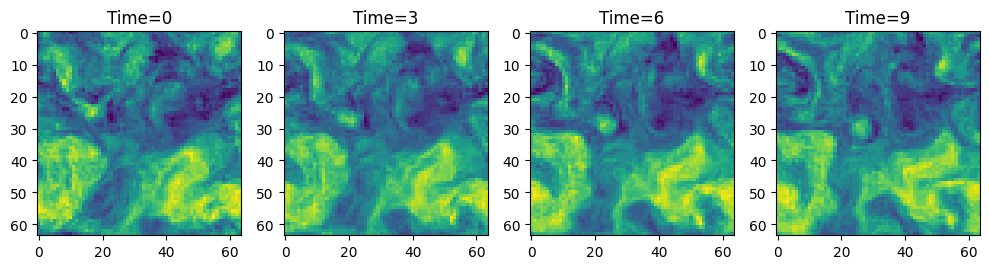

In [48]:
with torch.no_grad():
    # Generates a trajectory of latent samples across time steps (API: sde.sample(steps) -> [T, C, H, W] or [T, ...])
    x = sde.sample(steps=64).detach().cpu()
    x = x.unflatten(0, (-1, 2))

fig, axes = plt.subplots(1, 4, figsize=(10, 40))

axes[0].imshow(x[0][0])
axes[0].set_title(f"Time=0")

axes[1].imshow(x[3][0])
axes[1].set_title(f"Time=3")

axes[2].imshow(x[6][0])
axes[2].set_title(f"Time=6")

axes[3].imshow(x[9][0])
axes[3].set_title(f"Time=9")

plt.tight_layout()

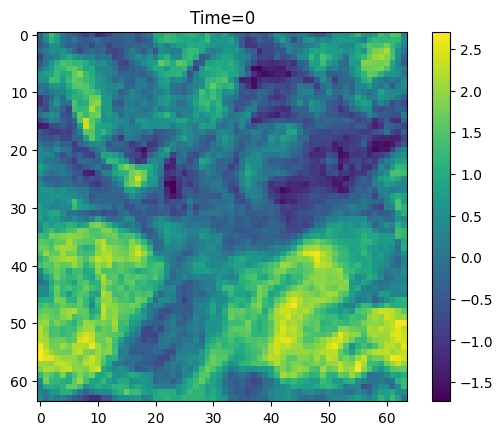

In [49]:
plt.imshow(x[0][0])
plt.title(f"Time=0")
plt.colorbar()

# Do assimilation

In [50]:
class TrajectoryDataset(Dataset):
    def __init__(
        self,
        file: Path,
        window: int = None,
        flatten: bool = False,
        normalize: float = True,
    ):
        super().__init__()

        with h5py.File(file, mode='r') as f:
            self.data = f['x'][:]

        self.window = window
        self.flatten = flatten
        self.normalize = normalize
        self.mean = self.data.mean()
        self.std = self.data.std()

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, i: int) -> Tuple[Tensor, Dict]:
        x = torch.from_numpy(self.data[i])

        if self.normalize:
            x = (x - self.mean) / self.std

        if self.window is not None:
            i = torch.randint(0, len(x) - self.window + 1, size=())
            x = torch.narrow(x, dim=0, start=i, length=self.window)

        if self.flatten:
            return x.flatten(0, 1), {}
        else:
            return x, {}
            
def A(x):
    return x[..., ::4, ::4]

data_dir = "/central/scratch/sotakao/sqg_train_data"
train_fname = "sqg_pv_train.h5"
valid_fname = "sqg_pv_valid.h5"

window = 10
trainset = TrajectoryDataset(os.path.join(data_dir, train_fname), normalize=True, window=window, flatten=True)
validset = TrajectoryDataset(os.path.join(data_dir, valid_fname), normalize=True, window=window, flatten=True)

x_star = validset[0][0]
# x_star = x_star.unflatten(0, (-1, 2))
y_star = torch.normal(A(x_star), 0.1)

# guided_sde = VPSDE(
#     DPSGaussianScore(
#         y_star,
#         A=A,
#         zeta=1.0,
#         sde=VPSDE(score, shape=()),
#     ),
#     shape=x_star.shape,
# ).cuda()

guided_sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        # sde=VPSDE(score, shape=()),
        sde=sde
    ),
    shape=x_star.shape,
).cuda()

In [51]:
# posterior_sample = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
posterior_sample = guided_sde.sample(steps=100).cpu()
posterior_sample = posterior_sample.unflatten(0, (-1, 2))

100%|█████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.55it/s]


Text(0.5, 1.0, 'SDA sample (t=4)')

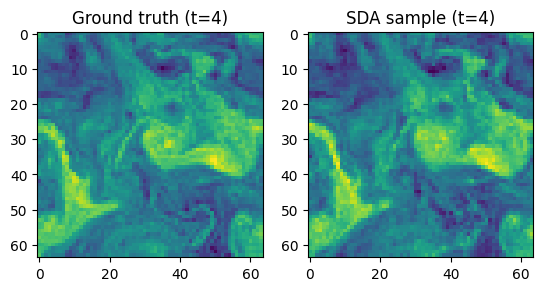

In [52]:
t = 4
x_star_ = x_star.unflatten(0, (-1, 2))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(x_star_[t,0])
axs[0].set_title(f"Ground truth (t={t})")
axs[1].imshow(posterior_sample[t,0])
axs[1].set_title(f"SDA sample (t={t})")

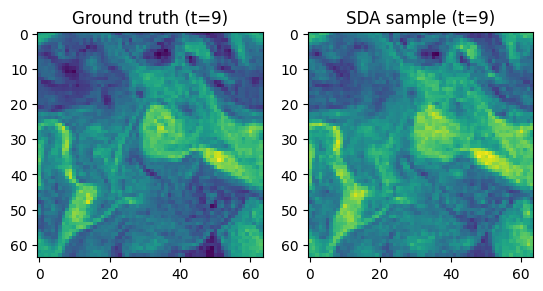

In [53]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming x_star_ and posterior_sample are already defined
x_star_ = x_star.unflatten(0, (-1, 2))

fig, axs = plt.subplots(1, 2)

def update(t):
    axs[0].clear()
    axs[1].clear()
    
    axs[0].imshow(x_star_[t, 0])
    axs[0].set_title(f"Ground truth (t={t})")
    
    axs[1].imshow(posterior_sample[t, 0])
    axs[1].set_title(f"SDA sample (t={t})")

ani = FuncAnimation(fig, update, frames=range(10), interval=500)  # 500ms per frame

# Save
ani.save('sda_posterior.gif', writer='imagemagick')

plt.show()